In [1]:
from IPython import get_ipython
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba_array, Normalize
from sklearn.mixture import GaussianMixture
from sklearn.cluster import Birch
from skimage.transform import resize
from skimage.io import imread, imshow, imsave
from skimage.color import rgb2hsv, hsv2rgb
from skimage import exposure, img_as_ubyte, img_as_float
import numpy as np
from pathlib import Path
import os

In [2]:
# HELPER FUNCTIONS

# File lister:
def file_lister(folder, suffix='jpg'):
    '''List files in folder derived from current work dir.
    listing files with specified suffix in subfolders 
    derived from current work dir or inside current work dir.
    Args:
    ---
        folder: string, name of subfolder to find in if you
                need listing in current dir, just type '.' as
                folder.
        suffix: string, suffix of files, like 'jpg', 'png' etc.
    '''
    basepath = Path(os.getcwd())
    pics_list= list(basepath.glob(f'{folder}/*.{suffix}'))
    return pics_list


# Load image as array
def load_im(path, as_float=False, plugin=None):
    '''Loads image as array.

    takes a string or path-like object and loads image using
    skimage.io.imread into array (like numpy array).

    Args:
    ---
        path: string or path-like object,. path to image.
        as_float: if True, retturns image as float array
        plugin: can be GDAL, PIL ... GDAL -> good for GeoTIFF
                default is None.
    '''
    if as_float == True:
        im = imread(path, plugin)
        im = img_as_float(im)
        return im
    else:
        im = imread(path, plugin)
        return im

def split_bands(im):
    band_list = []
    n_bands = im.shape[-1]
    for band in range(n_bands):
        single_band = im[:, :, band]
        band_list.append(single_band)
    return band_list
        
    
# Resize image by factor
def im_resize(im, fact):
    '''Resizes image by factor.

    takes numpy array IMAGE and resizes it by given factor.

    Args:
    ---
        im: image as numpy array.
        fact: integer number as a factor for floor division of image.
    '''
    im = resize(im,
    (im.shape[0] // fact, im.shape[1] // fact),
    anti_aliasing=True)
    return im

# Display palette colors
def show_pal(pal):
    fig, ax = plt.subplots()
    ax.set_yticklabels([])
    # ax.set_xticklabels([])
    idxs = np.arange(len(pal)).reshape(3,int(len(pal)/3))
    imshow(pal[idxs])
    counter = 0
    for i in range(3):
        for j in range(int(len(pal)/3)):
            ax.annotate(pal.tolist()[counter],(j,i), ha='center')
            counter += 1

# Save image array
def save_im(name, arr, pal):
    imsave(name, pal[arr])

# Scikit-learn selected usupervised clutering
def label_predict(im_arr, cls_type, nc, n_dim, cov_t='full'):
    '''Performs selected clustering method and returns img array

    takes image array(like-np.array) reshapes it to corretct shape
    for scikit-clustering, makes computation and returns labels as
    np.array with shape of input image.

    Args:
    ---
        im_arr:  input image as numpy array
        cls_type: 1 is GaussianMixture, 2 is Birch -- clusternig 
        nc: number of components/clusters
        n_dim: dimension of input raster, usually int "3" for RGB image
        cov_t: only for GaussianMixture,
                covariance_type{‘full’, ‘tied’, ‘diag’, ‘spherical’}, default=’full’
    '''
    # preprocess image to coorect shape for clustering
    x = im_arr.shape[0]
    y = im_arr.shape[1]
    im = im_arr.reshape(-1, n_dim)
    # GaussianMixture
    if cls_type == 1:
        cls = GaussianMixture(n_components=nc, covariance_type=cov_t, random_state=0).fit(im)
        lbl = cls.predict(im)
        lbl = lbl.reshape(x, y)
        return lbl
    # Birch
    elif cls_type == 2:
        cls = Birch(n_clusters=nc).fit(im)
        lbl = cls.predict(im)
        lbl = lbl.reshape(x, y)
        return lbl
    else:
        print('Something wrong happened with "label_predict')
        
'''POLAR PLOT OF HSV PALETTE AND IMAGE'''
def plot_polar_hsv(hsv_im, rgb_im, size=10):
    # HSV color palette around circle
    xval = np.arange(0, 2*np.pi, 0.01)
    yval = np.ones_like(xval)
    color_m = plt.get_cmap('hsv')
    norm = Normalize(0.0, 2*np.pi)

    # HSV image components reshape for X and Y axes
    hsv_im_H = (hsv_im[:, :, 0]*2*np.pi).reshape(-1,1)
    hsv_im_S = hsv_im[:, :, 1].reshape(-1,1)
    hsv_im_V = hsv_im[:, :, 2].reshape(-1,1)
    hsv_im_SV = np.sqrt(hsv_im_S*hsv_im_V)
    # Create RGBA palete of HSV img-pixels
    rgba = np.dstack((rgb_im, np.ones(rgb_im.shape[:-1])))
    colormap = rgba.reshape(-1,4)

    fig = plt.figure(figsize=(18,18))
    ax1 = fig.add_subplot(231, projection='polar')
    ax2 = fig.add_subplot(232, projection='polar')
    ax3 = fig.add_subplot(233, projection='polar')
    ax4 = fig.add_subplot(234)
    ax5 = fig.add_subplot(235)
    ax6 = fig.add_subplot(236)
    ax1.scatter(hsv_im_H, hsv_im_S, c=colormap, s=size, alpha=0.75, edgecolors=None )
    ax1.scatter(xval, yval, c=xval, s=30, cmap=color_m, norm=norm, linewidths=0)
    ax2.scatter(hsv_im_H, hsv_im_V, c=colormap, s=size, alpha=0.75, edgecolors=None )
    ax2.scatter(xval, yval, c=xval, s=30, cmap=color_m, norm=norm, linewidths=0)
    ax3.scatter(hsv_im_H, hsv_im_SV, c=colormap, s=size, alpha=0.75, edgecolors=None )
    ax3.scatter(xval, yval, c=xval, s=30, cmap=color_m, norm=norm, linewidths=0)
    ax4.scatter(hsv_im_H, hsv_im_S, c=colormap, s=size, alpha=0.75, edgecolors=None )
    ax4.scatter(xval, yval, c=xval, s=30, cmap=color_m, norm=norm, linewidths=0)
    ax5.scatter(hsv_im_H, hsv_im_V, c=colormap, s=size, alpha=0.75, edgecolors=None )
    ax5.scatter(xval, yval, c=xval, s=30, cmap=color_m, norm=norm, linewidths=0)
    ax5.set_yticks([])
    ax6.scatter(hsv_im_H, hsv_im_SV, c=colormap, s=size, alpha=0.75, edgecolors=None )
    ax6.scatter(xval, yval, c=xval, s=30, cmap=color_m, norm=norm, linewidths=0)
    ax6.set_yticks([])
    plt.show()
    
def plot_samples(pics, rows=3,cols=4, offset=0, fig_x=16, fig_y=9):
    offset = offset
    rows, cols = rows, cols
    f, ax = plt.subplots(rows, cols,figsize=(fig_x,fig_y)) 
    count = 0
    for row in range(rows):
        for col in range(cols):
            pic_name = pics[count+offset].parts[-1]
            img = imread(pics[count+offset])
            ax[row, col].imshow(img)
            ax[row, col].set_yticklabels([])
            ax[row, col].set_xticklabels([])
            ax[row, col].annotate(f'{pic_name} \nIndex: {count}',
                                  (0.1, 0.5), xycoords='axes fraction', va='center')
            count += 1

    plt.subplots_adjust(wspace=0, hspace=0.1)
    plt.show()
    
def plot_hist(im):
    if im.ndim > 2:
        for color, chnl in zip('rgb', np.rollaxis(im, axis=-1)):
            counts, bins_centers = exposure.histogram(chnl)
            plt.plot(bins_centers, counts, color=color, alpha=0.5)
    else:
        counts, bins_centers = exposure.histogram(im)
        plt.plot(bins_centers, counts, alpha=0.5)

In [3]:
# VARIABLE ASIGN
CO_PAL = np.array([
    [188,  14,  65],# 0)  Cervena -  nesplane budovy 
    [243, 149, 174],# 1)  Ruzova - vinohrady
    [237, 206,  65],# 2)  Zluta - spalne budovy
    [  0,   0,   0],# 3)  Cerna - hranice parcel, cisla parcel,popisy
    [109,  91,  92],# 4)  Tmavohneda - lesy
    [242, 216, 193],# 5)  Okrova - pole
    [ 49, 131, 103],# 6)  Syta zelena - parky, zahrady
    [133, 200, 155],# 7)  Zelena - louky
    [192, 224, 187],# 8)  Svetla zelena - pastviny
    [243, 248, 245],# 9)  Bila - verejna prost., neobd. puda, nadvori
    [196, 176, 165],# 10) Hneda - cesty
    [187, 234, 254]#  11) Modra - vodni plochy 
])

IMG_IDX = 4 # index of image to work with from file_lister
RESC_FACT = 30 # rescale factor for image array rescale
N_CLUST = 12 # nuber of clusters for clustering
N_CHNLS = 3 # nuber of image chanells

In [4]:
# LISTING IMAGES IN SUBFOLDERS
all_imgs = file_lister('cb_then_wb') # images contrast and white balanced in GIMP
oall_imgs = file_lister('samples') # original images

In [ ]:
# PREVIEW OF 12 BALANCED SAMPLES
plot_samples(all_imgs)

In [ ]:
# PREVIEW OF 12 ORIGINAL SAMPLES
plot_samples(oall_imgs)

In [ ]:
# PICK ONE IMG AND RESCALES IT
bal_im = im_resize(load_im(all_imgs[IMG_IDX]), RESC_FACT) # one rescaled balanced image as array
orig_im = im_resize(load_im(oall_imgs[IMG_IDX]), RESC_FACT)# one original image as array

In [ ]:
# CONVERT IMAGE TO HSV-COLOR-SPACE
bal_im_hsv = rgb2hsv(bal_im)
orig_im_hsv = rgb2hsv(orig_im)

In [ ]:
# SHOW BALANCED AND ORIGINAL IMAGE CHOSEN FOR SEGMENTATION
# Figure
fig = plt.figure(figsize=(9,18))
# Axes
ax1=fig.add_subplot(121)
ax2=fig.add_subplot(122)
ax1.imshow(bal_im)
ax2.imshow(orig_im)


In [ ]:
# PLOT COLOR DISTRIBUTION OF BALANCED IMAGE
plot_polar_hsv(bal_im_hsv, bal_im, 1)
# --------------------------------------------------------------------------------------------------
#                      HUE - colors around circle from 0 to 360 degrees
#
#       -- SATURATION --                        -- VALUE --                -- sqrt(SAT*VALUE) --

In [ ]:
# PLOT COLOR DISTRIBUTION OF ORIGINAL IMAGE
plot_polar_hsv(orig_im_hsv, orig_im, 1)
# --------------------------------------------------------------------------------------------------
#                      HUE - colors around circle from 0 to 360 degrees
#
#       -- SATURATION --                        -- VALUE --                -- sqrt(SAT*VALUE) --

TODO:
 - stretch histogram using scikit-image (not GIMP)
 - preproces image with bilateral filtering (smooth colors and preserves edges)
   + PLS implement in OpenCV, skimage is very slow
 - test tresholding for segmentation
 - test different aproach to differ colors using combibnations of SATURATION and VALUE


In [5]:
rgb_ix4 = load_im(oall_imgs[4], True)

In [ ]:
del rgb_ix4

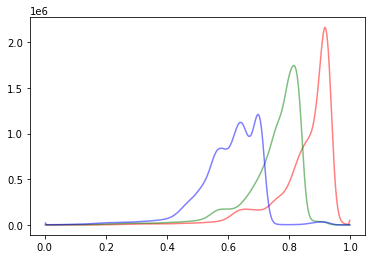

In [6]:
plot_hist(rgb_ix4)

In [7]:
hsv_ix4 = rgb2hsv(rgb_ix4)
H, S, V = split_bands(hsv_ix4)

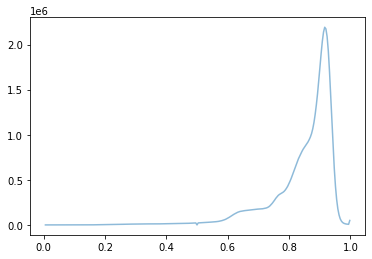

In [8]:
plot_hist(V)

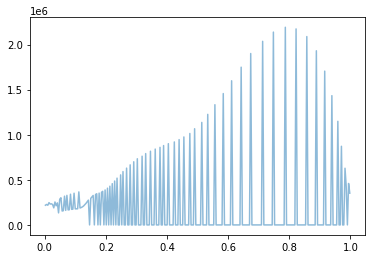

In [9]:
V_eq = exposure.equalize_hist(V)
plot_hist(V_eq)

In [10]:
%%time
hsv_ix4_V_eq = np.dstack((H,S,V_eq))

Wall time: 1.05 s


In [11]:
%%time
hsv_ix4_V_eq.shape


Wall time: 0 ns


(6892, 8477, 3)